#### price threshold 변경 (수수료 생각해서 손해보지 않을만큼 상승을 기준으로 파악)
#### 다시 삼진분류
#### Focal_loss
#### num_head 8
#### ff_dim 128

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow.keras.backend as K

In [2]:
# 데이터 로드
data = pd.read_csv('./000660.csv')

# 데이터 칼럼명 변경
data = data.rename(
    columns={
        '시가': 'Open',
        '고가': 'High',
        '저가': 'Low',
        '종가': 'Close',
        '거래량': 'Total_Volume',
        '매도량': 'Sell_Volume',
        '매수량': 'Buy_Volume'
    })

In [3]:
# 결측치 제거
data = data.dropna()

In [4]:
# 특성 선택
price_features = ['Open', 'High', 'Low', 'Close']
volume_features = ['Buy_Volume', 'Sell_Volume', 'Total_Volume']
features = price_features + volume_features

In [5]:
# 거래량 강도 계산
data['Volume_Intensity'] = data['Buy_Volume'] - data['Sell_Volume']
data['Volume_Intensity_Ratio'] = data['Volume_Intensity'] / (data['Total_Volume'] + 1e-5)
data['Buy_Sell_Ratio'] = data['Buy_Volume'] / (data['Sell_Volume'] + 1e-5)

In [6]:
# 새로운 특성들을 특성 리스트에 추가
features.extend(['Volume_Intensity', 'Volume_Intensity_Ratio', 'Buy_Sell_Ratio'])

In [7]:
# 이동 평균선 추가
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_20'] = data['Close'].rolling(window=20).mean()
data['MA_60'] = data['Close'].rolling(window=60).mean()
data['MA_5_20_Diff'] = data['MA_5'] - data['MA_20']
data['MA_20_60_Diff'] = data['MA_20'] - data['MA_60']

In [8]:
# 추가된 특성을 특성 리스트에 포함
features.extend(['MA_5', 'MA_20', 'MA_60', 'MA_5_20_Diff', 'MA_20_60_Diff'])

In [9]:
# 이동 평균선 계산 후 결측치 제거
data = data.dropna()

In [10]:
# 가격 급변 레이블링
price_threshold = 0.00  # 0.5% 이상 변동 시 급변으로 간주

data['Price_Change'] = data['Close'].pct_change()
data = data.dropna()

def label_price_change(change):
    if change >= price_threshold:
        return 2  # 상승
    elif change <= -price_threshold:
        return 0  # 하락
    else:
        return 1  # 보합

data['Price_Label'] = data['Price_Change'].apply(label_price_change)

In [11]:
# 결측치 제거 (최종)
data = data.dropna()

In [12]:
# 스케일러 딕셔너리 생성
scalers = {}

In [13]:
# 가격 관련 특성 스케일링
for feature in price_features + ['MA_5', 'MA_20', 'MA_60', 'MA_5_20_Diff', 'MA_20_60_Diff']:
    scaler = StandardScaler()
    data[feature] = scaler.fit_transform(data[[feature]])
    scalers[feature] = scaler

In [14]:
# 거래량 관련 특성 스케일링
for feature in volume_features + ['Volume_Intensity', 'Volume_Intensity_Ratio', 'Buy_Sell_Ratio']:
    scaler = RobustScaler()
    data[feature] = scaler.fit_transform(data[[feature]])
    scalers[feature] = scaler

In [15]:
# 시퀀스 생성 함수 정의
def create_sequences(data, sequence_length, expect, target):
    X = []
    y = []
    data_values = data[features].values
    labels = data[target].values
    for i in range(len(data_values) - sequence_length - expect + 1):
        X.append(data_values[i:i+sequence_length])
        y.append(labels[i+sequence_length + expect - 1])
    return np.array(X), np.array(y)

In [16]:
# 데이터 생성
sequence_length = 60  # 시퀀스 길이
expect = 10
X, y = create_sequences(data, sequence_length, target='Price_Label')

In [17]:
# 시간 순서대로 데이터 분할
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

In [18]:
# 클래스 분포 확인
unique, counts = np.unique(y_train, return_counts=True)
print("클래스 분포:", dict(zip(unique, counts)))

클래스 분포: {0: 203, 1: 130158, 2: 259}


In [19]:
# 하이퍼 파라미터 설정
d_model = X_train.shape[2]
num_heads = 8
ff_dim = 128
num_layers = 2
dropout_rate = 0.1
num_classes = 3  # 레이블 클래스 수

In [20]:
# 포지셔널 인코딩 정의
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_length, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(sequence_length, d_model)
    
    def get_config(self):
        config = super().get_config().copy()
        return config
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            np.arange(position)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model)
        
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)
    
    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [21]:
# 트랜스포머 블록 정의
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-Head Attention
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attn_output = layers.Dropout(dropout)(attn_output)
    out1 = layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    
    # Feed Forward Network
    ffn_output = layers.Dense(ff_dim, activation='gelu', kernel_regularizer=regularizers.l2(1e-4))(out1)
    ffn_output = layers.Dense(head_size)(ffn_output)
    ffn_output = layers.Dropout(dropout)(ffn_output)
    return layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

In [22]:
# 모델 정의
def create_model():
    inputs = layers.Input(shape=(sequence_length, d_model))
    x = PositionalEncoding(sequence_length, d_model)(inputs)
    
    for _ in range(num_layers):
        x = transformer_block(x, d_model, num_heads, ff_dim, dropout_rate)
    
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [23]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 15)]     0           []                               
                                                                                                  
 positional_encoding (Positiona  (None, 60, 15)      0           ['input_1[0][0]']                
 lEncoding)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 60, 15)      7575        ['positional_encoding[0][0]',    
 dAttention)                                                      'positional_encoding[0][0]']    
                                                                                              

In [24]:
# 클래스 가중치 계산
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [25]:
class_weights

{0: 9.974799541809851, 1: 0.3578414451731676, 2: 9.504475005457325}

In [26]:
# Focal Loss 구현
def focal_loss(gamma=2., alpha=0.25):

    def focal_loss_fixed(y_true, y_pred):
        y_true = K.cast(y_true, dtype='int32')
        y_true = K.one_hot(y_true, num_classes)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = - y_true * alpha * K.pow(1 - y_pred, gamma) * K.log(y_pred)
        loss = K.sum(loss, axis=-1)
        return K.mean(loss)
    
    return focal_loss_fixed

In [27]:
# 모델 컴파일
model.compile(
    loss=focal_loss(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

In [28]:
# 모델 체크포인트 콜백 설정
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./model_transformer2/best_model_2_09.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [29]:
# 콜백 리스트에 포함
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    checkpoint_callback
]

In [30]:
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/100
8162/8164 [============================>.] - ETA: 0s - loss: 0.0484 - accuracy: 0.9307
Epoch 1: val_loss improved from inf to 0.03098, saving model to ./model_transformer2\best_model_2_09.h5
8164/8164 [==============================] - 159s 19ms/step - loss: 0.0484 - accuracy: 0.9307 - val_loss: 0.0310 - val_accuracy: 0.9437
Epoch 2/100
8164/8164 [==============================] - ETA: 0s - loss: 0.0455 - accuracy: 0.9315
Epoch 2: val_loss improved from 0.03098 to 0.02873, saving model to ./model_transformer2\best_model_2_09.h5
8164/8164 [==============================] - 157s 19ms/step - loss: 0.0455 - accuracy: 0.9315 - val_loss: 0.0287 - val_accuracy: 0.9437
Epoch 3/100
8164/8164 [==============================] - ETA: 0s - loss: 0.0442 - accuracy: 0.9315
Epoch 3: val_loss did not improve from 0.02873
8164/8164 [==============================] - 149s 18ms/step - loss: 0.0442 - accuracy: 0.9315 - val_loss: 0.0297 - val_accuracy: 0.9437
Epoch 4/100
8164/8164 [=============

KeyboardInterrupt: 

In [31]:
# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

875/875 [==============================] - 8s 9ms/step - loss: 0.0950 - accuracy: 0.7201
Test Accuracy: 0.7201


In [32]:
# 자세한 성능 평가
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_classes))

875/875 [==============================] - 6s 7ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3907
           1       0.72      1.00      0.84     20157
           2       0.00      0.00      0.00      3927

    accuracy                           0.72     27991
   macro avg       0.24      0.33      0.28     27991
weighted avg       0.52      0.72      0.60     27991



c:\ProgramData\anaconda3\envs\final_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\final_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\final_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

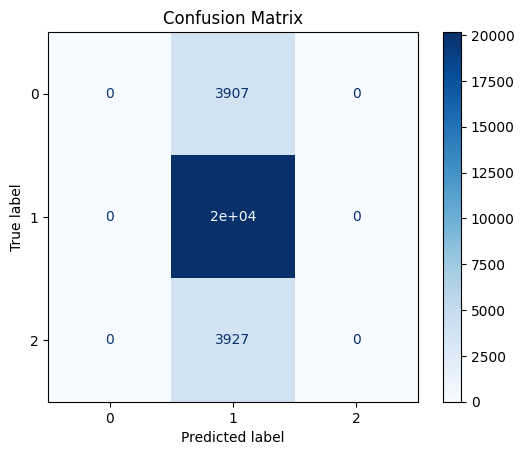

In [33]:
import matplotlib.pyplot as plt
# 혼동 행렬 계산 및 시각화
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [34]:
# 정확도 시각화
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# 손실 시각화
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

<Figure size 640x480 with 0 Axes>